In [1]:
#Encerrar a conexão com os dispositivos
DAC.close()
scope.close()
rm.close()


NameError: name 'DAC' is not defined

In [37]:
import pyvisa as pv
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   
import pickle
import scipy.signal
from tqdm.notebook import tqdm, trange
from scipy.special import erfc
import scipy as sp
from optic.comm.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample, decimate,clockSamplingInterp,symbolSync
from optic.comm.metrics import signal_power,fastBERcalc
from optic.dsp.equalization import *
from optic.plot import eyediagram
plt.rcParams["figure.figsize"] = (12,6)

from funcoesLab import *

In [2]:
# #Conectar dispositivos

rm = pv.ResourceManager()
print(rm.list_resources())

DAC = rm.open_resource('USB0::0x0957::0x5707::MY53802202::0::INSTR')

print('info DAC:', DAC.query('*IDN?'))

DAC.write('*rst')
DAC.write('*opc?') 

scope = rm.open_resource('USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
print('Info Osciloscopio:', scope.query('*IDN?'))
scope.write('*rst')
scope.write('*opc?') 

np.set_printoptions(threshold=np.inf)
del DAC.timeout
print('')

('USB0::0x0957::0x5707::MY53802202::0::INSTR', 'USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
info DAC: Agilent Technologies,33622A,MY53802202,A.01.11-2.25-03-64-02

Info Osciloscopio: KEYSIGHT TECHNOLOGIES,DSO-X 3014T,MY55440748,04.06.2015051201




In [31]:
Modulador = {
    'M': 4,
    'nsimbolos': 2e5,
    'SPS': 5,
    'formatoPulso': 'rrc', #'rect','nrz','rrc'
    'nTaps': 2048,
    'alpha': 0.01,
    'W': np.array([])
}

Dac = {
    'dispositivo': DAC,
    'Porta': 2,
    'fs': 100e6,
    'V_High': 4,
    'V_Low': 0,
    'filtro': 'NORMal'
}

Osciloscopio = {
    'dispositivo': scope,
    'canais': np.array([3]),
    'tempo': 1*Modulador['nsimbolos']/(Dac['fs']),
    'vDivisao': np.array([0.5]),
    'impedancia': np.array(['FIFTy']),
    'triggerChannel': np.array([0]),
    'triggerAmp': np.array([0]),
    'offset': np.array([2]),
}
#Gerando os sinais transmitidos
bits, pulso,transmitido, transmitidoequalizados = Gerar_Simbolos(Modulador)
#Gerando uma onda arbitraria no DAC
Onda_Dac_Keysight(Dac,Modulador,transmitido,'teste')
DAC.query('*OPC?')   
#Configurando o osciloscopio
ConfigurarScope(Osciloscopio)
# Fixar o sinal no osciloscopio
Osciloscopio['dispositivo'].write('digitize')
Osciloscopio['dispositivo'].query('*OPC?')   

t,recebido = AdquirirOnda(Osciloscopio['dispositivo'],3)
fsScope = float(Osciloscopio['dispositivo'].query(':ACQuire:SRATe?'))

print(f'Numero de pontos do osciloscopio: {len(recebido)}')
print(f'Frequencia de amostragem do osciloscopio: {round(fsScope*1e-6,3)} MHz')



+0,"No error"

Numero de pontos do osciloscopio: 2000000
Frequencia de amostragem do osciloscopio: 1000.0 MHz


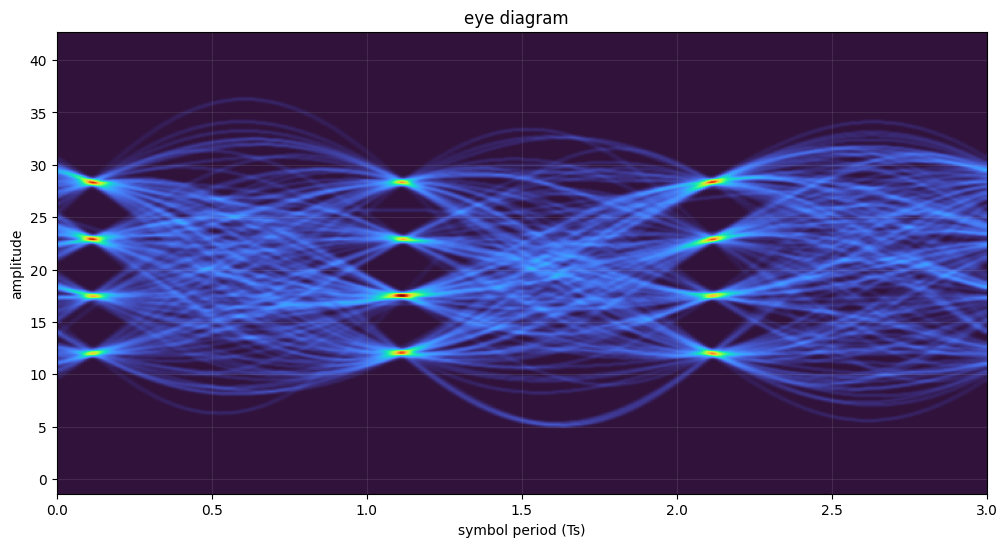

(1000000,)
(1000000,)
(1000000,)
(1000000,)


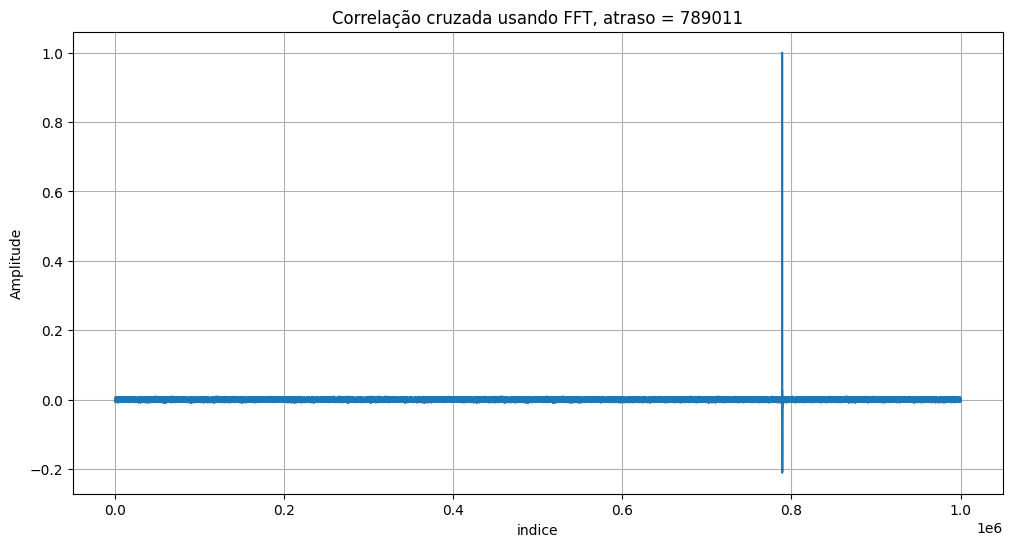

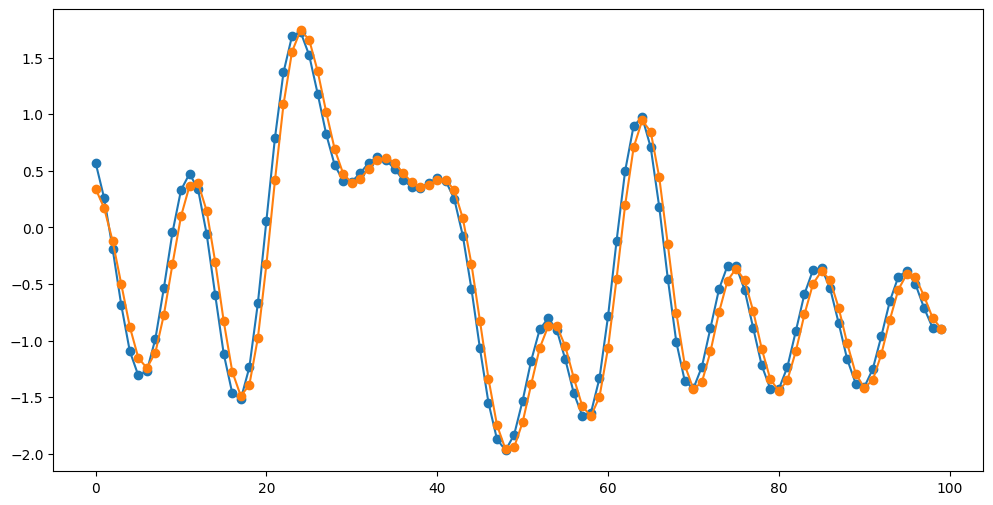

In [49]:
transmitido = pnorm(transmitido-np.mean(transmitido))

pulso = pulseShape(Modulador['formatoPulso'], int(fsScope//Dac['fs']), Modulador['nTaps'], Modulador['alpha'])
pulso = pulso/max(abs(pulso))
filtrocasado = firFilter(pulso,recebido)
eyediagram(filtrocasado,len(filtrocasado),int(fsScope//Dac['fs']),ptype='fancy')

from optic.utils import parameters
paramDec = parameters()
paramDec.SpS_in  = int(fsScope//Dac['fs'])
paramDec.SpS_out = int(Modulador['SPS'])
recebidodecimado = decimate(filtrocasado, paramDec)[:,0]
print((recebidodecimado.shape))
print((transmitido.shape))
recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))

recebidosicronizado = sicronizarSinais(recebidodecimado,(transmitido),plot=True)
#recebidosicronizado = symbolSync(transmitido.reshape(-1,1), recebidodecimado.reshape(-1,1), int(Modulador['SPS']))[:,0]
recebidosicronizado = np.roll(recebidosicronizado[0:len(transmitido)],0)

recebidosicronizado = pnorm(recebidosicronizado-np.mean(recebidosicronizado))

print((recebidosicronizado.shape))
print((transmitido.shape))
plt.figure()
plt.plot((transmitido)[0:100],'o-')
plt.plot((recebidosicronizado)[0:100],'o-')

#plt.figure()
#diferenca = transmitido - recebidosicronizado
#plt.plot(diferenca[0::len(diferenca)//10000])
#recebidodecimado = clockSamplingInterp(recebido.reshape(-1,1),Fs_in=fsScope,Fs_out=Dac['fs']*Modulador['SPS'],jitter_rms=0)[:,0]
#recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))

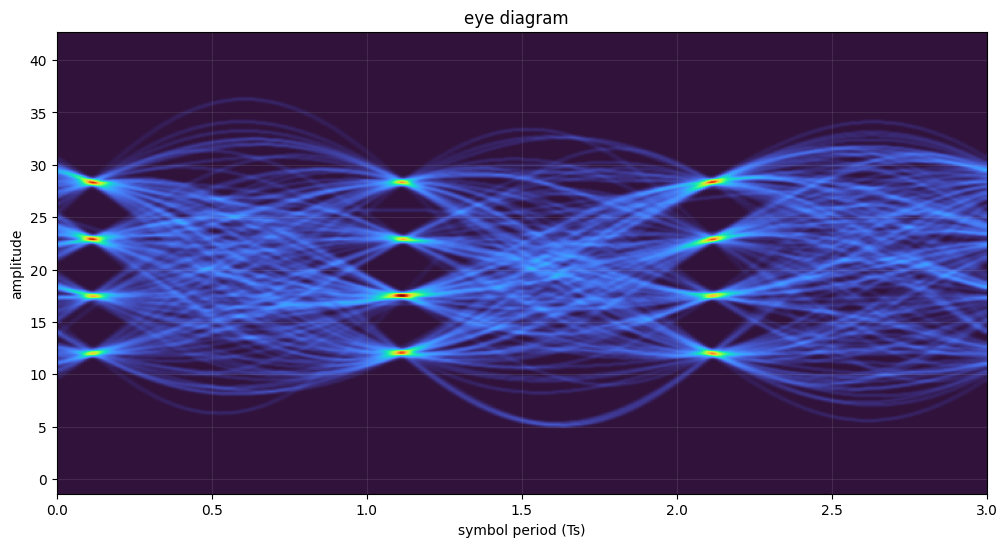

(200000,)
(1000000,)
(200000,)
(1000000,)


(array([7.5e-06]), array([1.e-05]), array([26.07205296]))

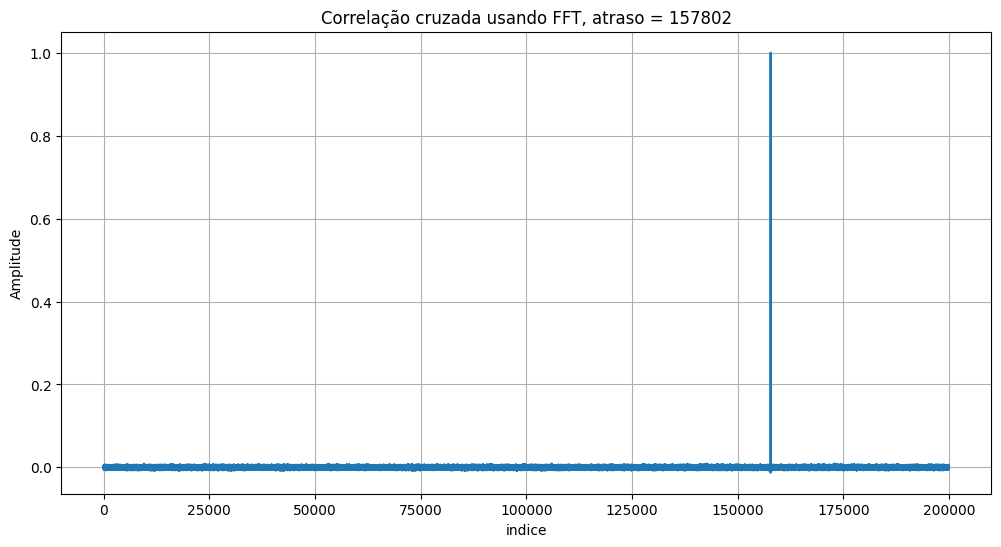

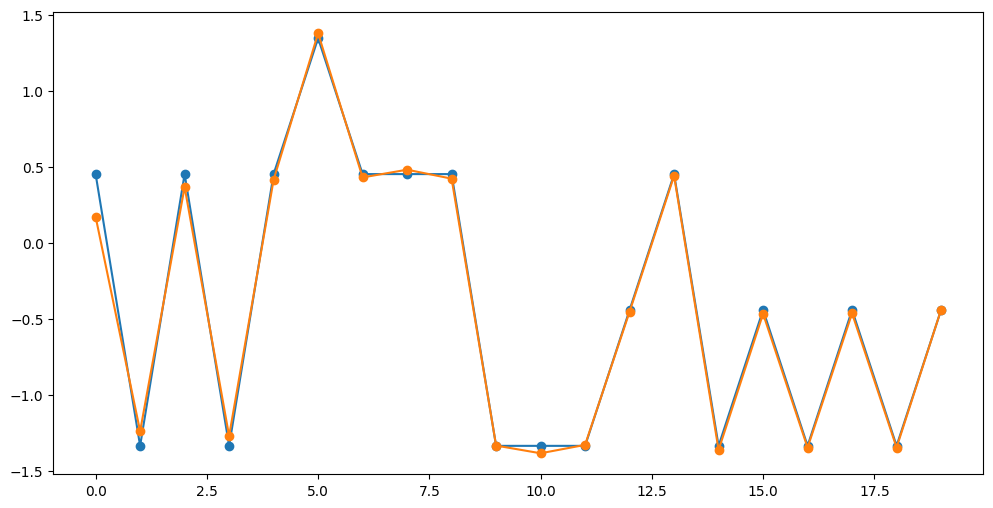

In [52]:
transmitido = pnorm(transmitido-np.mean(transmitido))

pulso = pulseShape(Modulador['formatoPulso'], int(fsScope//Dac['fs']), Modulador['nTaps'], Modulador['alpha'])
pulso = pulso/max(abs(pulso))
filtrocasado = firFilter(pulso,recebido)
eyediagram(filtrocasado,len(filtrocasado),int(fsScope//Dac['fs']),ptype='fancy')

from optic.utils import parameters
paramDec = parameters()
paramDec.SpS_in  = int(fsScope//Dac['fs'])
paramDec.SpS_out = 1
recebidodecimado = decimate(filtrocasado, paramDec)[:,0]
print((recebidodecimado.shape))
print((transmitido.shape))

simbolos = modulateGray(bits,4,'pam')
simbolos = pnorm(simbolos-np.mean(simbolos))

recebidosicronizado = sicronizarSinais(recebidodecimado,(simbolos),plot=True)
#recebidosicronizado = recebidosicronizado[0:len(transmitido)]
recebidosicronizado = pnorm(recebidosicronizado-np.mean(recebidosicronizado))

print((recebidodecimado.shape))
print((transmitido.shape))
plt.figure()
plt.plot((simbolos)[0:20],'o-')
plt.plot((recebidosicronizado)[0:20],'o-')
fastBERcalc(pnorm(recebidosicronizado), pnorm(simbolos), 4, 'pam')
# plt.figure()
# diferenca = transmitido - recebidosicronizado
# plt.plot(diferenca[0::len(diferenca)//1000])
#recebidodecimado = clockSamplingInterp(recebido.reshape(-1,1),Fs_in=fsScope,Fs_out=Dac['fs']*Modulador['SPS'],jitter_rms=0)[:,0]
#recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))

In [ ]:
from optic.dsp.clockRecovery import gardnerClockRecovery


paramCLKREC = parameters()
paramCLKREC.isNyquist = True
paramCLKREC.returnTiming = True
paramCLKREC.ki = 1e-6
paramCLKREC.kp = 5e-3
paramCLKREC.maxPPM = -200

outCLK, ted_values = gardnerClockRecovery(sigRx, paramCLKREC)